# Sistema Inteligente de Classificação de Personagens dos Simpsons

Este notebook implementa um sistema completo de classificação de imagens para identificar personagens dos Simpsons, inspirado na estrutura do sistema de classificação de sementes de soja.

## Objetivo

- Extrair características de imagens usando descritores
- Treinar e comparar classificadores (Random Forest, SVM, k-NN)
- Avaliar desempenho com métricas e matriz de confusão

**Alunos:** Alexandre Borges Baccarini Júnior, Leonardo, Mateus

## 1. Instalação e Importação de Bibliotecas

In [ ]:
# Instale as bibliotecas necessárias (execute apenas uma vez)
%pip install numpy pandas scikit-learn scikit-image matplotlib seaborn Pillow

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from skimage.feature import local_binary_pattern
from scipy.signal import convolve2d
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

## 2. Funções de Extração de Características (LBP, LPQ)

In [3]:
def lbp(image: np.ndarray, P: int = 8, R: int = 2, method: str = 'nri_uniform'):
    assert isinstance(image, np.ndarray) and len(image.shape) == 2
    desc = local_binary_pattern(image, P, R, method=method)
    n_bins = int(desc.max() + 1)
    hist, _ = np.histogram(desc, density=True, bins=n_bins, range=(0, n_bins))
    return hist

def lpq(img, winSize=7, decorr=1, mode='nh'):
    rho = 0.90
    STFTalpha = 1/winSize
    convmode = 'valid'
    img = np.float64(img)
    r = (winSize-1)/2
    x = np.arange(-r, r+1)[np.newaxis]
    w0 = np.ones_like(x)
    w1 = np.exp(-2*np.pi*x*STFTalpha*1j)
    w2 = np.conj(w1)
    filterResp1 = convolve2d(convolve2d(img, w0.T, convmode), w1, convmode)
    filterResp2 = convolve2d(convolve2d(img, w1.T, convmode), w0, convmode)
    filterResp3 = convolve2d(convolve2d(img, w1.T, convmode), w1, convmode)
    filterResp4 = convolve2d(convolve2d(img, w1.T, convmode), w2, convmode)
    freqResp = np.dstack([filterResp1.real, filterResp1.imag,
                          filterResp2.real, filterResp2.imag,
                          filterResp3.real, filterResp3.imag,
                          filterResp4.real, filterResp4.imag])
    inds = np.arange(freqResp.shape[2])[np.newaxis, np.newaxis, :]
    LPQdesc = ((freqResp > 0) * (2**inds)).sum(2)
    if mode == 'nh' or mode == 'h':
        LPQdesc = np.histogram(LPQdesc.flatten(), range(257))[0]
    if mode == 'nh':
        LPQdesc = LPQdesc / LPQdesc.sum()
    return LPQdesc

## 3. Carregamento e Extração de Características das Imagens

In [4]:
def extract_features_from_directory(base_path, descriptor='lbp'):
    features = []
    labels = []
    for class_name in sorted(os.listdir(base_path)):
        class_dir = os.path.join(base_path, class_name)
        if not os.path.isdir(class_dir):
            continue
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img_path = os.path.join(class_dir, fname)
                try:
                    img = Image.open(img_path).convert('L')
                    img = np.array(img)
                    if descriptor == 'lbp':
                        feat = lbp(img)
                    elif descriptor == 'lpq':
                        feat = lpq(img)
                    else:
                        raise ValueError("Descriptor inválido")
                    features.append(feat)
                    labels.append(class_name)
                except Exception as e:
                    print(f"Erro ao processar {img_path}: {e}")
    return np.array(features), np.array(labels)

## 4. Preparação dos Dados

In [5]:
# Defina o caminho para o dataset (ajuste conforme sua estrutura)
base_path = "./imgs/Train"  # Exemplo: "./imgs/Train" com subpastas para cada personagem

# Extraia características LBP
X, y = extract_features_from_directory(base_path, descriptor='lbp')
print(f"Total de amostras: {X.shape[0]}, Dimensão das features: {X.shape[1]}")
print("Classes:", np.unique(y))

# Codificar labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

Total de amostras: 169, Dimensão das features: 59
Classes: ['bart' 'homer' 'lisa' 'maggie' 'marge']


## 5. Treinamento e Avaliação dos Classificadores

In [6]:
def train_and_evaluate_classifier(clf, X_train, y_train, X_test, y_test, class_names):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=class_names))
    acc = accuracy_score(y_test, y_pred)
    print(f"Acurácia: {acc:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.title("Matriz de Confusão")
    plt.show()
    return acc

Random Forest:
              precision    recall  f1-score   support

        bart       0.53      0.83      0.65        12
       homer       0.60      0.33      0.43         9
        lisa       0.00      0.00      0.00         5
      maggie       0.25      0.40      0.31         5
       marge       1.00      0.33      0.50         3

    accuracy                           0.47        34
   macro avg       0.48      0.38      0.38        34
weighted avg       0.47      0.47      0.43        34

Acurácia: 0.4706


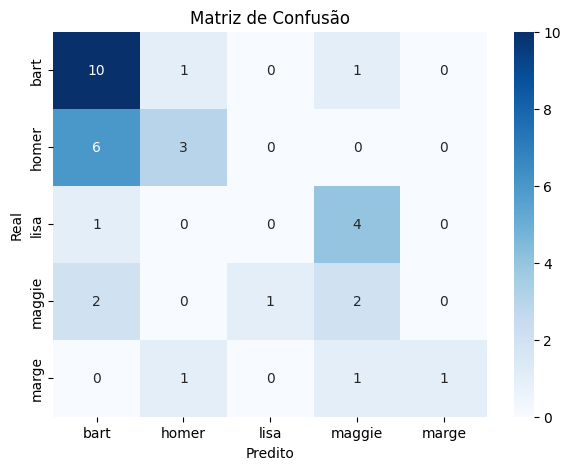

SVM:
              precision    recall  f1-score   support

        bart       0.50      0.75      0.60        12
       homer       0.50      0.33      0.40         9
        lisa       0.33      0.20      0.25         5
      maggie       0.33      0.40      0.36         5
       marge       1.00      0.33      0.50         3

    accuracy                           0.47        34
   macro avg       0.53      0.40      0.42        34
weighted avg       0.50      0.47      0.45        34

Acurácia: 0.4706


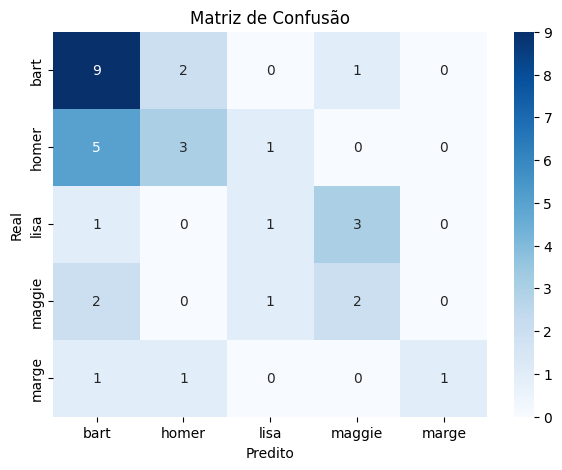

k-NN:
              precision    recall  f1-score   support

        bart       0.50      0.75      0.60        12
       homer       0.14      0.11      0.12         9
        lisa       0.57      0.80      0.67         5
      maggie       0.50      0.20      0.29         5
       marge       0.00      0.00      0.00         3

    accuracy                           0.44        34
   macro avg       0.34      0.37      0.34        34
weighted avg       0.37      0.44      0.38        34

Acurácia: 0.4412


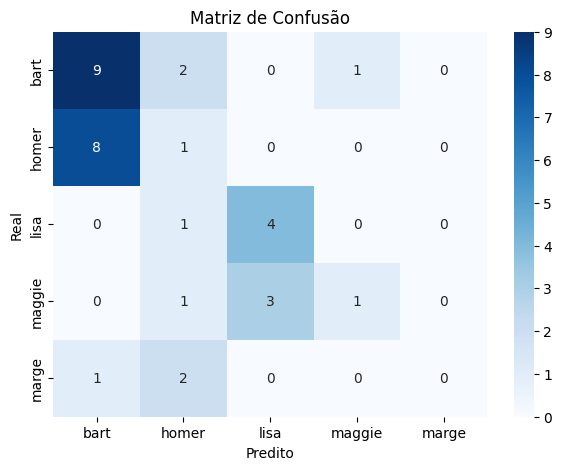

0.4411764705882353

In [7]:
# Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest
print("Random Forest:")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
train_and_evaluate_classifier(rf, X_train_scaled, y_train, X_test_scaled, y_test, le.classes_)

# SVM
print("SVM:")
svm = SVC(kernel='rbf', random_state=42)
train_and_evaluate_classifier(svm, X_train_scaled, y_train, X_test_scaled, y_test, le.classes_)

# k-NN
print("k-NN:")
knn = KNeighborsClassifier(n_neighbors=5)
train_and_evaluate_classifier(knn, X_train_scaled, y_train, X_test_scaled, y_test, le.classes_)

## 6. Comparação entre LBP e LPQ

Repita a extração e avaliação usando LPQ para comparar os resultados.

Random Forest (LPQ):
              precision    recall  f1-score   support

        bart       0.67      0.83      0.74        12
       homer       0.50      0.44      0.47         9
        lisa       0.60      0.60      0.60         5
      maggie       0.40      0.40      0.40         5
       marge       1.00      0.33      0.50         3

    accuracy                           0.59        34
   macro avg       0.63      0.52      0.54        34
weighted avg       0.60      0.59      0.58        34

Acurácia: 0.5882


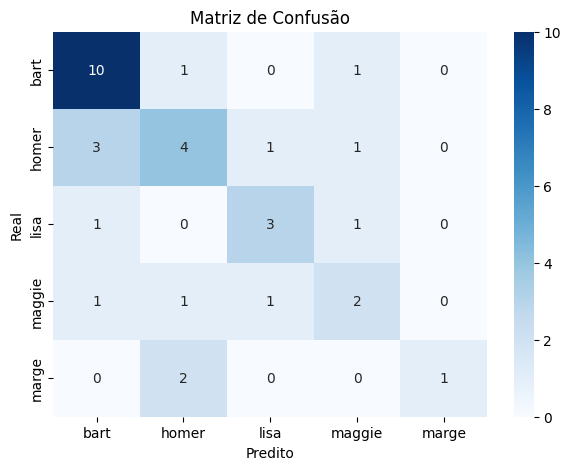

0.5882352941176471

In [8]:
# Extração de características LPQ
X_lpq, y_lpq = extract_features_from_directory(base_path, descriptor='lpq')
y_lpq_encoded = le.transform(y_lpq)
X_train_lpq, X_test_lpq, y_train_lpq, y_test_lpq = train_test_split(X_lpq, y_lpq_encoded, test_size=0.2, random_state=42, stratify=y_lpq_encoded)

X_train_lpq_scaled = scaler.fit_transform(X_train_lpq)
X_test_lpq_scaled = scaler.transform(X_test_lpq)

print("Random Forest (LPQ):")
train_and_evaluate_classifier(RandomForestClassifier(n_estimators=100, random_state=42), X_train_lpq_scaled, y_train_lpq, X_test_lpq_scaled, y_test_lpq, le.classes_)

## 7. Otimização de Hiperparâmetros com GridSearchCV

Vamos otimizar os principais classificadores usando GridSearchCV para ambos os descritores (LBP e LPQ).

Otimização com LBP:
Random Forest melhores parâmetros: {'max_depth': None, 'n_estimators': 50}
              precision    recall  f1-score   support

        bart       0.50      0.75      0.60        12
       homer       0.50      0.33      0.40         9
        lisa       0.00      0.00      0.00         5
      maggie       0.33      0.60      0.43         5
       marge       1.00      0.33      0.50         3

    accuracy                           0.47        34
   macro avg       0.47      0.40      0.39        34
weighted avg       0.45      0.47      0.42        34

Acurácia: 0.4706


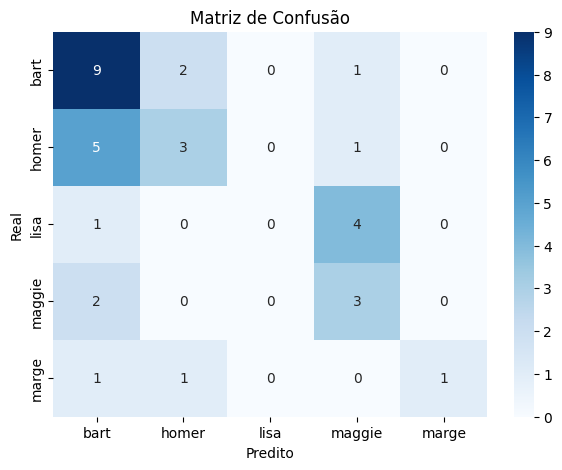

SVM melhores parâmetros: {'C': 10, 'gamma': 0.01}
              precision    recall  f1-score   support

        bart       0.62      0.67      0.64        12
       homer       0.30      0.33      0.32         9
        lisa       0.33      0.40      0.36         5
      maggie       0.50      0.40      0.44         5
       marge       1.00      0.33      0.50         3

    accuracy                           0.47        34
   macro avg       0.55      0.43      0.45        34
weighted avg       0.51      0.47      0.47        34

Acurácia: 0.4706


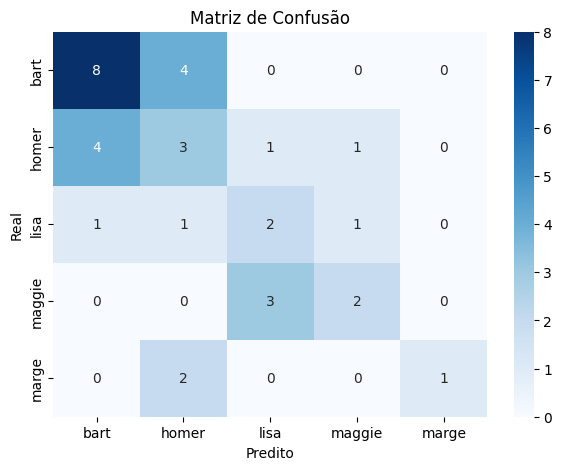

k-NN melhores parâmetros: {'n_neighbors': 7}
              precision    recall  f1-score   support

        bart       0.53      0.83      0.65        12
       homer       0.33      0.22      0.27         9
        lisa       0.67      0.80      0.73         5
      maggie       0.50      0.20      0.29         5
       marge       0.00      0.00      0.00         3

    accuracy                           0.50        34
   macro avg       0.41      0.41      0.38        34
weighted avg       0.45      0.50      0.45        34

Acurácia: 0.5000


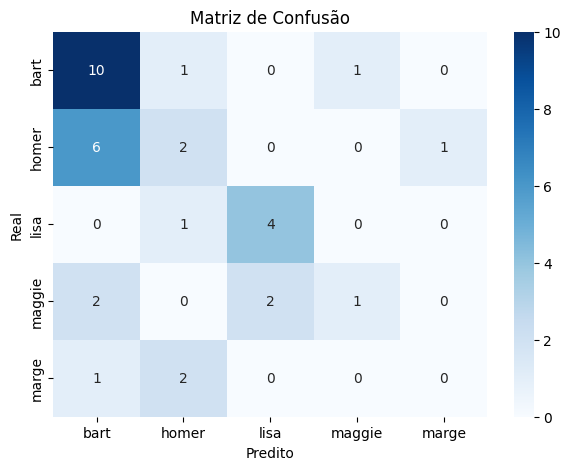

In [9]:
# GridSearchCV para Random Forest, SVM e k-NN com LBP

def grid_search_all(X_train, y_train, X_test, y_test, class_names):
    results = {}
    # Random Forest
    rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
    rf_gs = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, n_jobs=-1)
    rf_gs.fit(X_train, y_train)
    print("Random Forest melhores parâmetros:", rf_gs.best_params_)
    acc_rf = train_and_evaluate_classifier(rf_gs.best_estimator_, X_train, y_train, X_test, y_test, class_names)
    results['RandomForest'] = acc_rf

    # SVM
    svm_params = {'C': [0.1, 1, 10], 'gamma': ['scale', 0.01, 0.1]}
    svm_gs = GridSearchCV(SVC(kernel='rbf', random_state=42), svm_params, cv=3, n_jobs=-1)
    svm_gs.fit(X_train, y_train)
    print("SVM melhores parâmetros:", svm_gs.best_params_)
    acc_svm = train_and_evaluate_classifier(svm_gs.best_estimator_, X_train, y_train, X_test, y_test, class_names)
    results['SVM'] = acc_svm

    # k-NN
    knn_params = {'n_neighbors': [3, 5, 7]}
    knn_gs = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3, n_jobs=-1)
    knn_gs.fit(X_train, y_train)
    print("k-NN melhores parâmetros:", knn_gs.best_params_)
    acc_knn = train_and_evaluate_classifier(knn_gs.best_estimator_, X_train, y_train, X_test, y_test, class_names)
    results['k-NN'] = acc_knn

    return results

print("Otimização com LBP:")
results_lbp = grid_search_all(X_train_scaled, y_train, X_test_scaled, y_test, le.classes_)

Otimização com LPQ:
Random Forest melhores parâmetros: {'max_depth': None, 'n_estimators': 200}
              precision    recall  f1-score   support

        bart       0.62      0.83      0.71        12
       homer       0.43      0.33      0.38         9
        lisa       0.75      0.60      0.67         5
      maggie       0.50      0.60      0.55         5
       marge       1.00      0.33      0.50         3

    accuracy                           0.59        34
   macro avg       0.66      0.54      0.56        34
weighted avg       0.61      0.59      0.57        34

Acurácia: 0.5882


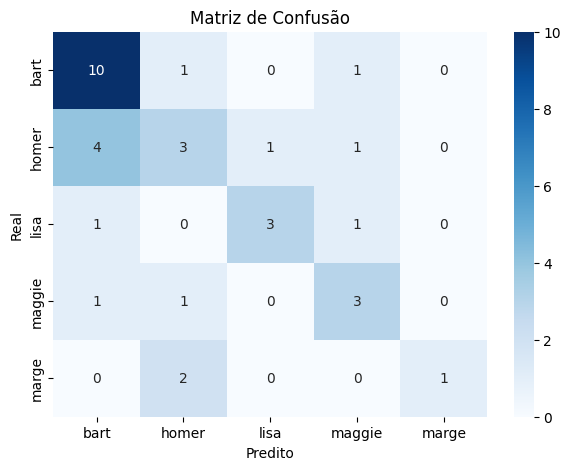

SVM melhores parâmetros: {'C': 10, 'gamma': 'scale'}
              precision    recall  f1-score   support

        bart       0.71      0.83      0.77        12
       homer       0.60      0.33      0.43         9
        lisa       1.00      0.60      0.75         5
      maggie       0.45      1.00      0.62         5
       marge       0.00      0.00      0.00         3

    accuracy                           0.62        34
   macro avg       0.55      0.55      0.51        34
weighted avg       0.62      0.62      0.59        34

Acurácia: 0.6176


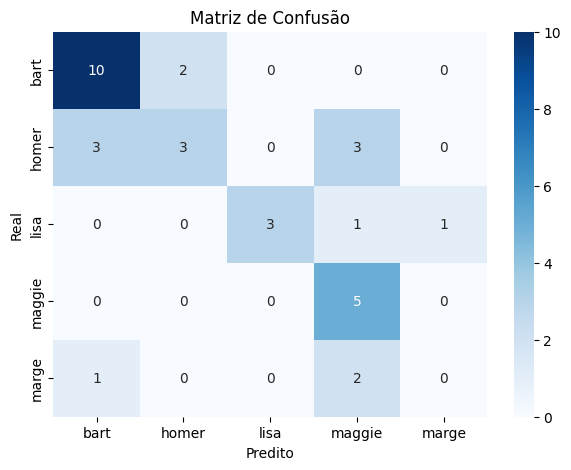

k-NN melhores parâmetros: {'n_neighbors': 3}
              precision    recall  f1-score   support

        bart       0.71      0.42      0.53        12
       homer       0.38      0.67      0.48         9
        lisa       0.38      0.60      0.46         5
      maggie       0.33      0.20      0.25         5
       marge       0.00      0.00      0.00         3

    accuracy                           0.44        34
   macro avg       0.36      0.38      0.34        34
weighted avg       0.46      0.44      0.42        34

Acurácia: 0.4412


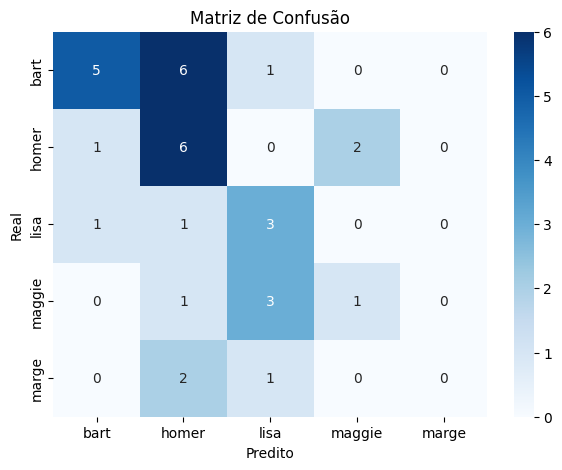

In [10]:
# GridSearchCV para Random Forest, SVM e k-NN com LPQ

print("Otimização com LPQ:")
results_lpq = grid_search_all(X_train_lpq_scaled, y_train_lpq, X_test_lpq_scaled, y_test_lpq, le.classes_)